This is a simple demonstration of image processing using dask arrays with [ghost cells](http://dask.pydata.org/en/latest/array-ghost.html).

We apply the Canny edge detection algorithm to our image. Which is suitable for ghosted arrays because it is relatively "local", that is each pixel depends on pixel only a small fixed distance away.

The algorithm applies a Gaussian filter to the image and then takes the 2D gradient. Points where the gradient is larger than some threshold are "edges".

So we create a dask array, then use it's `map_overlap` method to apply the edge detection function.


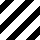
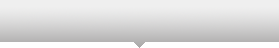
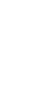
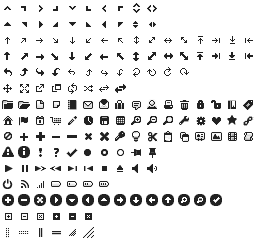
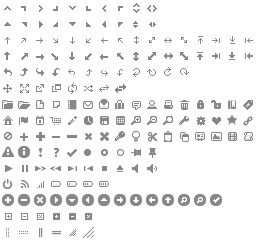
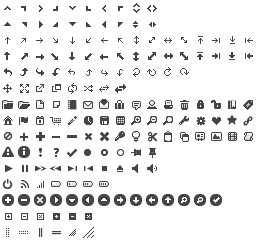
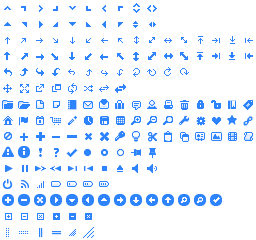
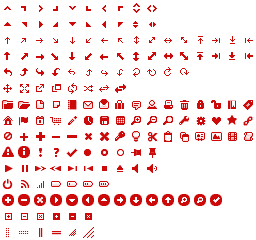
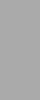
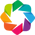
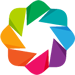
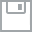
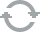
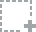
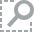
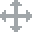
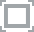
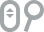

In [1]:
from os.path import getsize

from bokeh.plotting import figure, show, output_notebook
output_notebook()

import numpy as np
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.io import imread

import dask.array as da
from dask.diagnostics import ProgressBar

In [ ]:
! wget http://imgsrc.hubblesite.org/hu/db/images/hs-2004-07-a-full_jpg.jpg

If we assume the file is too large to load into memory, how would I load it?

In [2]:
file_name = 'hs-2004-07-a-full_jpg.jpg' # hubble ultra deep field
color_img = imread(file_name) # ~ 61MB

In [3]:
color_img.shape, color_img.nbytes * 1e-6 # still in memory here

((6200, 6200, 3), 115.32)

In [4]:
# convert to greyscale
img = rgb2gray(color_img)  # this reshapes the array, so it is 2D now.
img.shape

(6200, 6200)

So we have the image in a numpy array. How does it look? We downsample this x100 so it does not crash the browser.

In [5]:
p = figure(x_range=(0, 620), y_range=(0, 620))
p.image([img[::15, ::15]], x=[0], y=[0], dw=[620], dh=[620])
show(p)

So lets create a dask array with this Numpy array.

In [6]:
arr = da.from_array(img, chunks=(1000, 1000))
arr.nbytes * 1e-6

307.51999999999998

In [7]:
arr

dask.array<from-ar..., shape=(6200, 6200), dtype=float64, chunksize=(1000, 1000)>

We wrap the scikit image canny function so we can pass it to dask array.

In [8]:
def func(block):
    return canny(block, sigma=1.)

Now we can add the padding. We choose 50 pixels. And the external boundary to be periodic.

In [9]:
padding = {0: 50, 1:50}
boundary = {0: 'periodic', 1:'periodic'}
canny_array = arr.map_overlap(func, depth=padding, boundary=boundary)

In [10]:
with ProgressBar():
    out = canny_array.compute()

[########################################] | 100% Completed |  7.8s


We lets zoom in on an interesting section of this image. Loading the whole thing might crash the browser.

In [11]:
x0, x1 = 4700, 5300
y0, y1 = 2400, 3000
slice_ = slice(x0, x1), slice(y0, y1)
xr = x0 - x1
yr = y0 - y1
from bokeh.models.mappers import LinearColorMapper

cmap = LinearColorMapper(palette=['#ffffff', '#000000'], low=0, high=1, )
p = figure(x_range=(0, xr), y_range=(0, yr))
p.image([out[slice_].astype(float)], x=[0], y=[0], dw=[xr], dh=[yr], color_mapper=cmap)
show(p)